In [1]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
# Create the rational expectation version of Cagan model in finite time
CaganREE = namedtuple("CaganREE", 
                        ["m0", "T", "μ_seq", "α", "δ", "π_end"])

def create_cagan_model(m0, α, T, μ_seq):
    δ = α/(1 + α)
    π_end = μ_seq[-1]    # compute terminal expected inflation
    return CaganREE(m0, T, μ_seq, α, δ, π_end)

In [3]:
# parameters
T = 80
T1 = 60
α = 5
m0 = 1

μ0 = 0.5
μ_star = 0

In [4]:
def solve(model):
    model_params = model.m0, model.T, model.π_end, model.μ_seq, model.α, model.δ
    m0, T, π_end, μ_seq, α, δ = model_params
    A1 = np.eye(T+1, T+1) - δ * np.eye(T+1, T+1, k=1)
    A2 = np.eye(T+1, T+1) - np.eye(T+1, T+1, k=-1)

    b1 = (1-δ) * μ_seq + np.concatenate([np.zeros(T), [δ * π_end]])
    b2 = μ_seq + np.concatenate([[m0], np.zeros(T)])

    π_seq = np.linalg.inv(A1) @ b1
    m_seq = np.linalg.inv(A2) @ b2

    π_seq = np.append(π_seq, π_end)
    m_seq = np.append(m0, m_seq)

    p_seq = m_seq + α * π_seq

    return π_seq, m_seq, p_seq

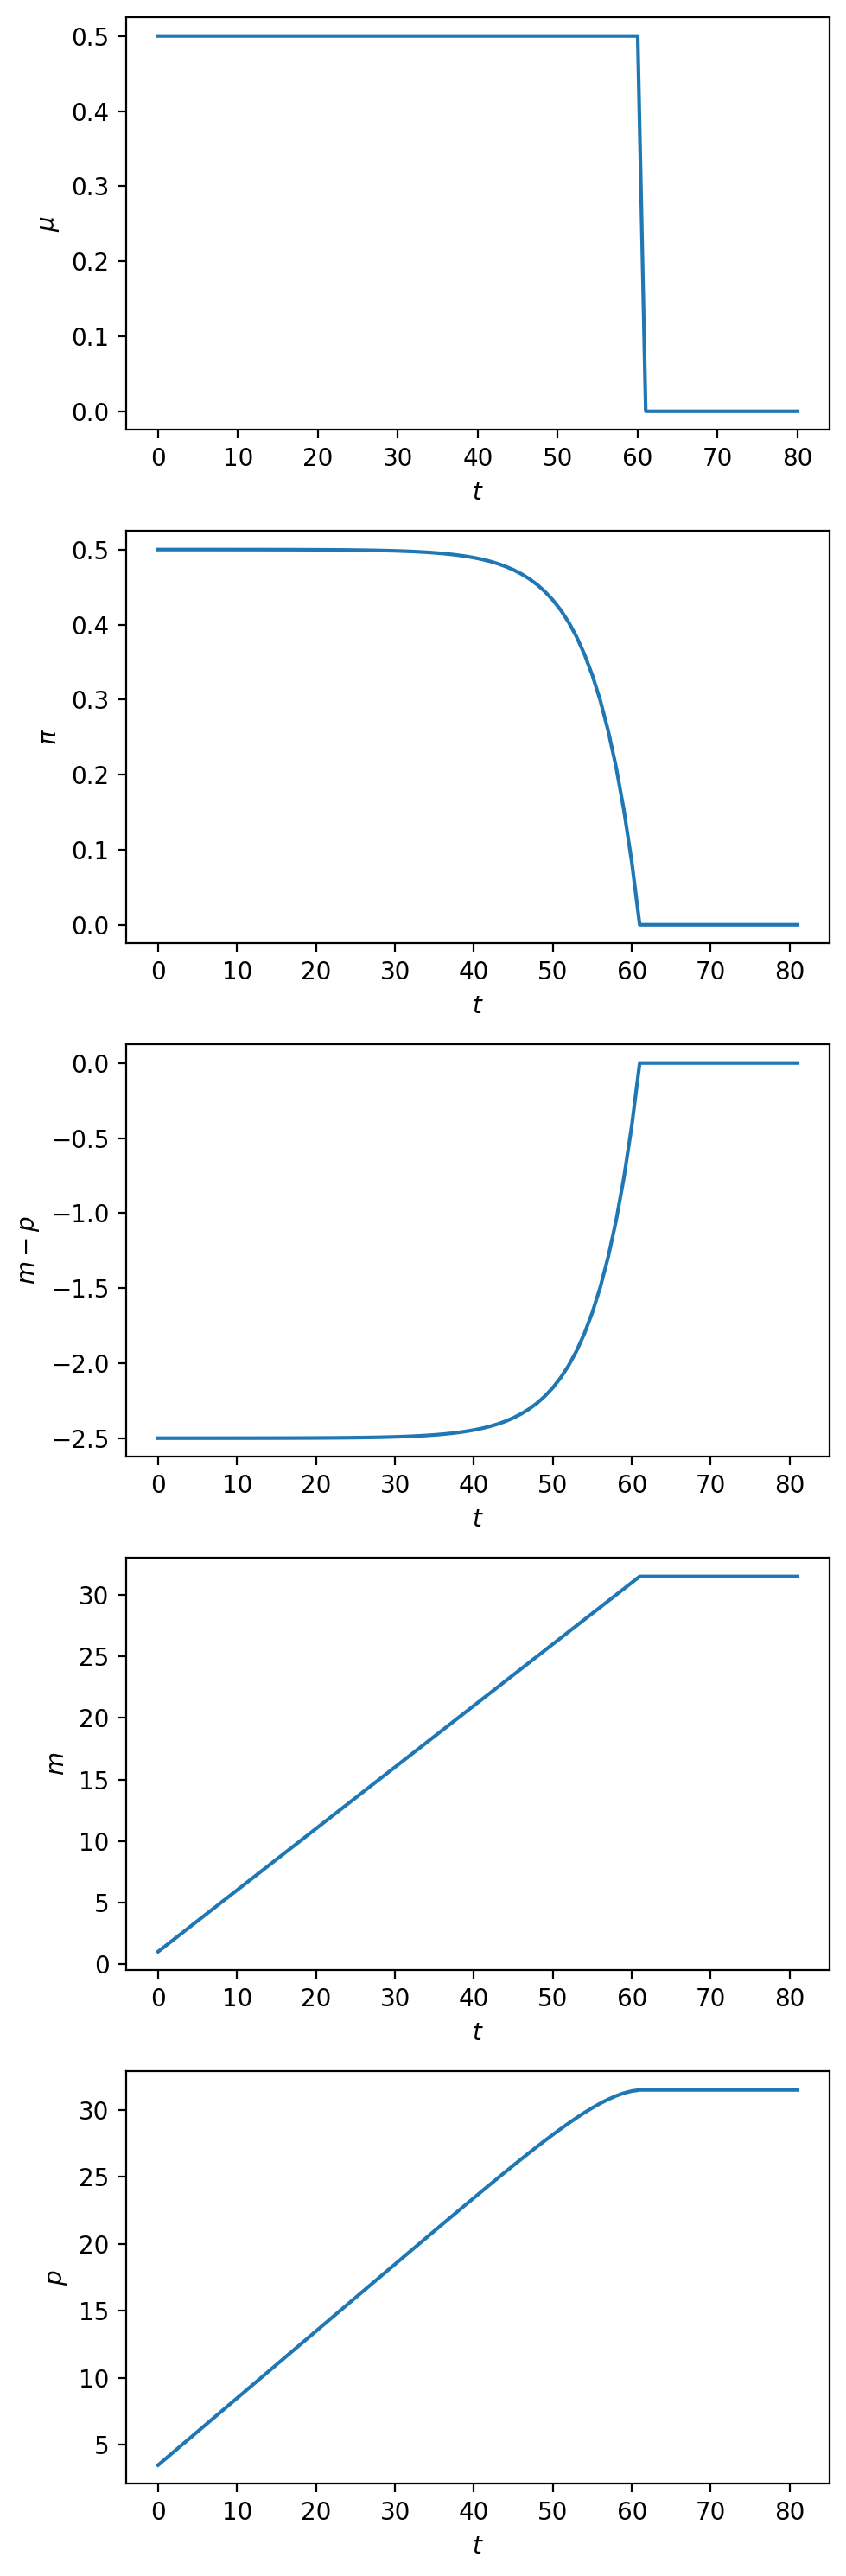

In [5]:
def solve_and_plot(m0, α, T, μ_seq):
    model_params = create_cagan_model(m0=m0, α=α, T=T, μ_seq=μ_seq)
    π_seq, m_seq, p_seq = solve(model_params)
    T_seq = range(T + 2)
    
    fig, ax = plt.subplots(5, figsize=[5, 15], dpi=200)
    
    ax[0].plot(T_seq[:-1], μ_seq)
    ax[0].set_ylabel(r'$\mu$')

    ax[1].plot(T_seq, π_seq)
    ax[1].set_ylabel(r'$\pi$')

    ax[2].plot(T_seq, m_seq - p_seq)
    ax[2].set_ylabel(r'$m - p$')

    ax[3].plot(T_seq, m_seq)
    ax[3].set_ylabel(r'$m$')

    ax[4].plot(T_seq, p_seq)
    ax[4].set_ylabel(r'$p$')
    
    for i in range(5):
        ax[i].set_xlabel(r'$t$')
                
    plt.tight_layout()
    plt.show()
    
    return π_seq, m_seq, p_seq

μ_seq_1 = np.append(μ0*np.ones(T1+1), μ_star*np.ones(T-T1))

# solve and plot
π_seq_1, m_seq_1, p_seq_1 = solve_and_plot(m0=m0, α=α, 
                                           T=T, μ_seq=μ_seq_1)

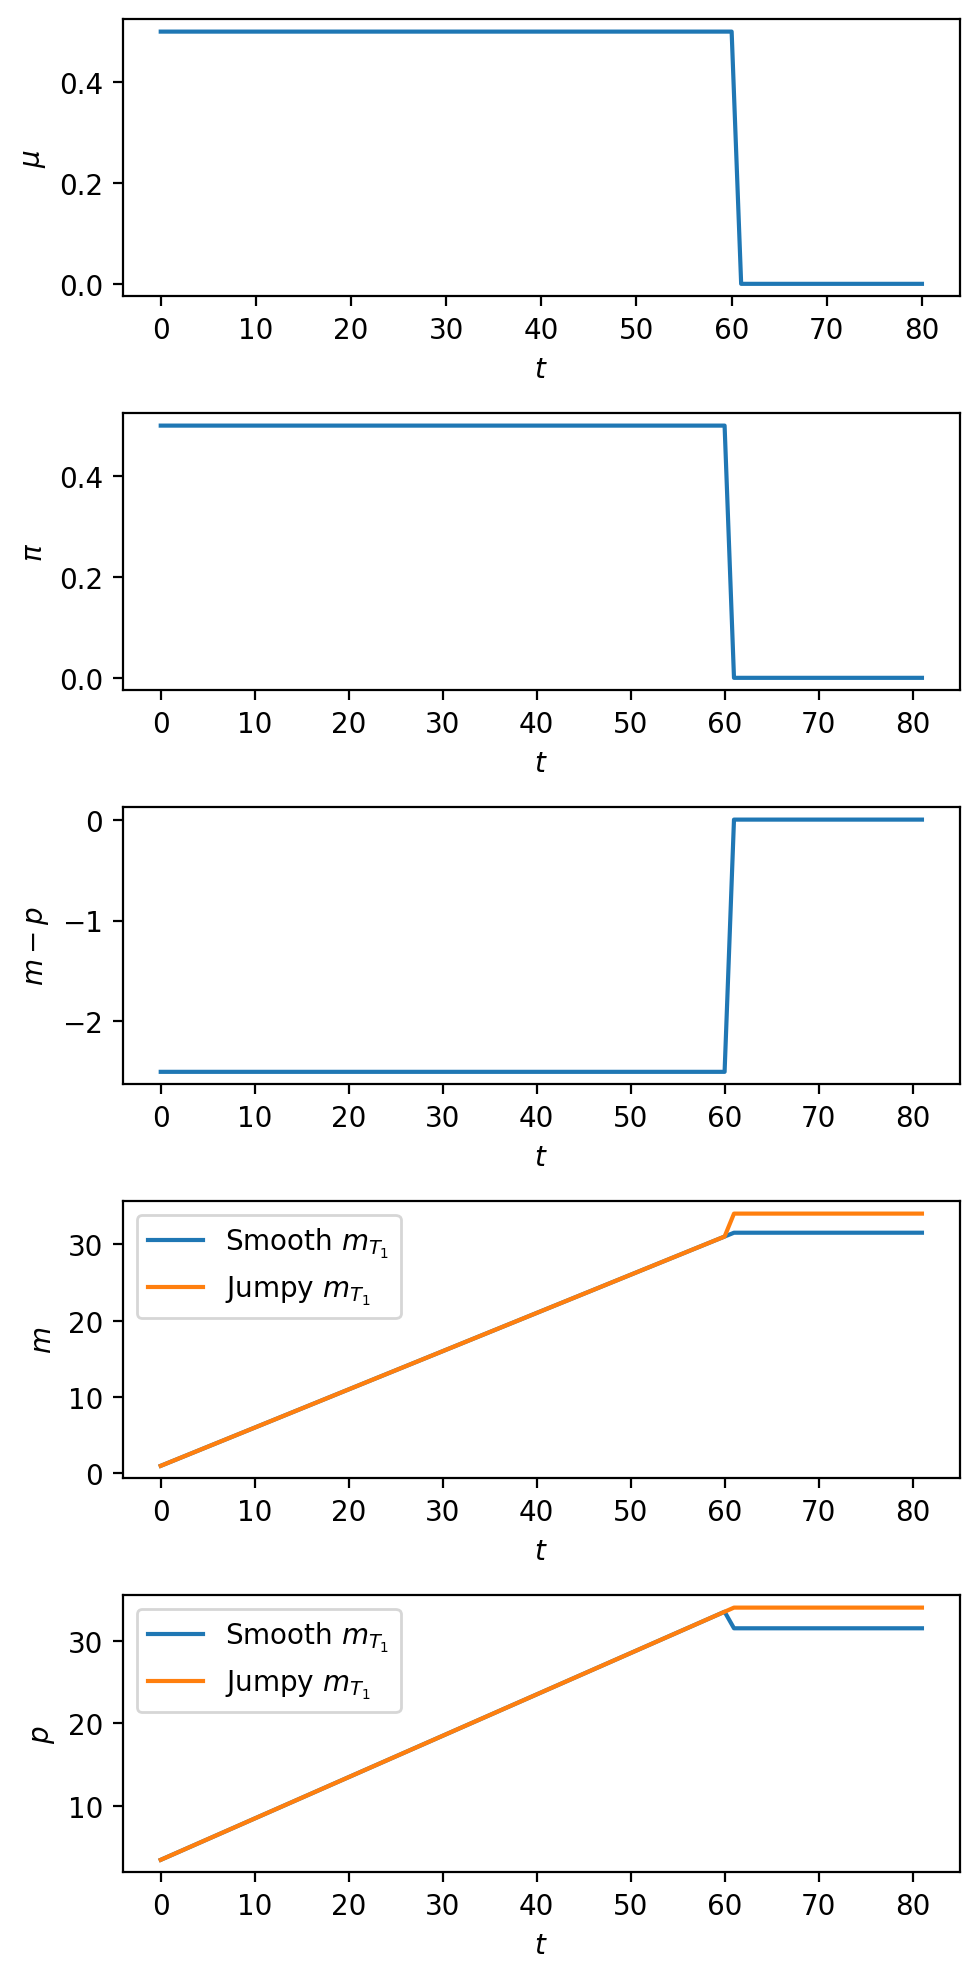

In [6]:
# path 1
μ_seq_2_path1 = μ0 * np.ones(T+1)

mc1 = create_cagan_model(m0=m0, α=α, 
                         T=T, μ_seq=μ_seq_2_path1)
π_seq_2_path1, m_seq_2_path1, p_seq_2_path1 = solve(mc1)

# continuation path
μ_seq_2_cont = μ_star * np.ones(T-T1)

mc2 = create_cagan_model(m0=m_seq_2_path1[T1+1], 
                         α=α, T=T-1-T1, μ_seq=μ_seq_2_cont)
π_seq_2_cont, m_seq_2_cont1, p_seq_2_cont1 = solve(mc2)


# regime 1 - simply glue π_seq, μ_seq
μ_seq_2 = np.concatenate([μ_seq_2_path1[:T1+1],
                          μ_seq_2_cont])
π_seq_2 = np.concatenate([π_seq_2_path1[:T1+1], 
                          π_seq_2_cont])
m_seq_2_regime1 = np.concatenate([m_seq_2_path1[:T1+1], 
                                  m_seq_2_cont1])
p_seq_2_regime1 = np.concatenate([p_seq_2_path1[:T1+1], 
                                  p_seq_2_cont1])

# regime 2 - reset m_T1
m_T1 = (m_seq_2_path1[T1] + μ0) + α*(μ0 - μ_star)

mc = create_cagan_model(m0=m_T1, α=α,
                        T=T-1-T1, μ_seq=μ_seq_2_cont)
π_seq_2_cont2, m_seq_2_cont2, p_seq_2_cont2 = solve(mc)

m_seq_2_regime2 = np.concatenate([m_seq_2_path1[:T1+1], 
                                  m_seq_2_cont2])
p_seq_2_regime2 = np.concatenate([p_seq_2_path1[:T1+1],
                                  p_seq_2_cont2])

T_seq = range(T+2)

# plot both regimes
fig, ax = plt.subplots(5, 1, figsize=[5,10], dpi=200)
 
ax[0].plot(T_seq[:-1], μ_seq_2)
ax[0].set_ylabel(r'$\mu$')

ax[1].plot(T_seq, π_seq_2)
ax[1].set_ylabel(r'$\pi$')

ax[2].plot(T_seq, m_seq_2_regime1 - p_seq_2_regime1)
ax[2].set_ylabel(r'$m - p$')

ax[3].plot(T_seq, m_seq_2_regime1, 
             label='Smooth $m_{T_1}$')
ax[3].plot(T_seq, m_seq_2_regime2, 
             label='Jumpy $m_{T_1}$')
ax[3].set_ylabel(r'$m$')

ax[4].plot(T_seq, p_seq_2_regime1,
             label='Smooth $m_{T_1}$')
ax[4].plot(T_seq, p_seq_2_regime2, 
             label='Jumpy $m_{T_1}$')
ax[4].set_ylabel(r'$p$')

for i in range(5):
    ax[i].set_xlabel(r'$t$')

for i in [3, 4]:
    ax[i].legend()

plt.tight_layout()
plt.show()

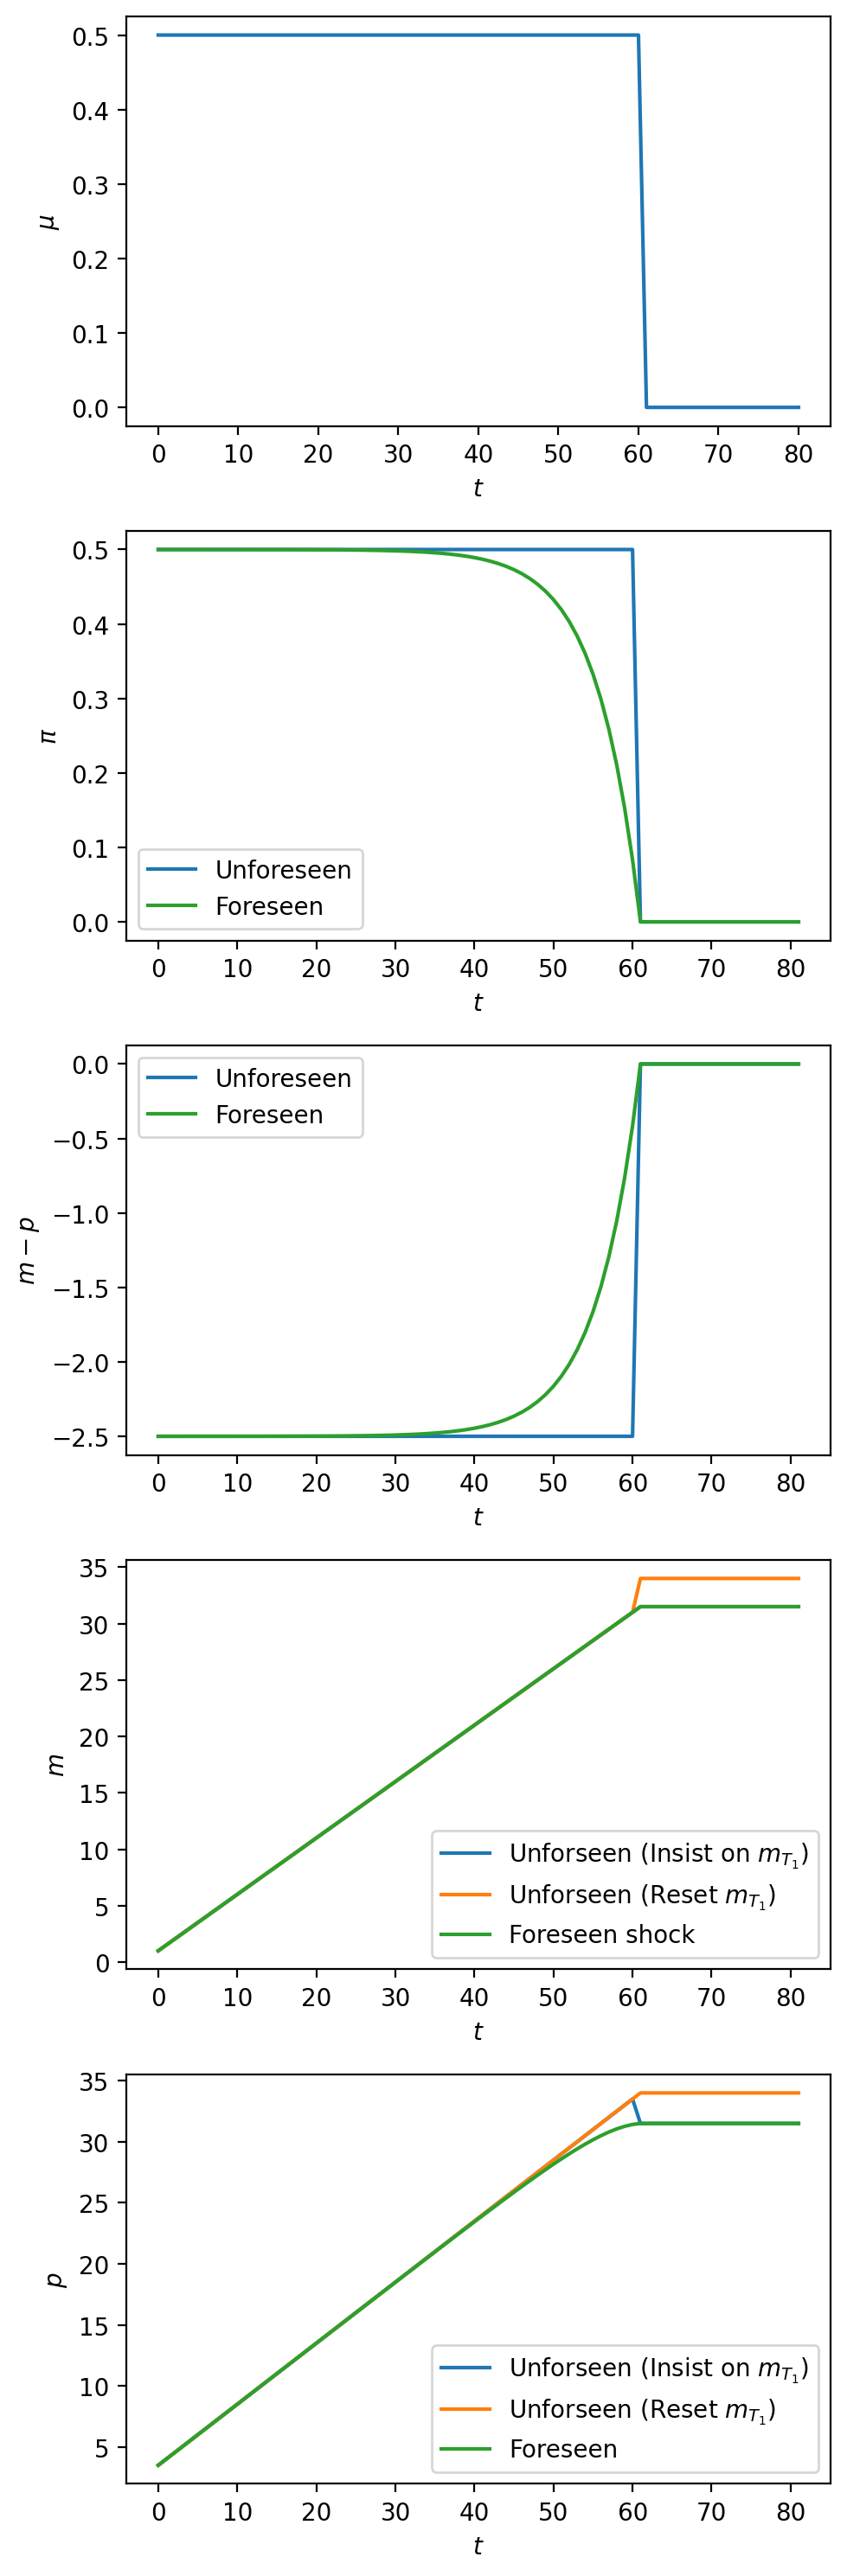

In [7]:
# compare foreseen vs unforeseen shock
fig, ax = plt.subplots(5, figsize=[5, 15], dpi=200)

ax[0].plot(T_seq[:-1], μ_seq_2)
ax[0].set_ylabel(r'$\mu$')

ax[1].plot(T_seq, π_seq_2, 
             label='Unforeseen')
ax[1].plot(T_seq, π_seq_1, 
             label='Foreseen', color='tab:green')
ax[1].set_ylabel(r'$\pi$')

ax[2].plot(T_seq,
             m_seq_2_regime1 - p_seq_2_regime1, 
             label='Unforeseen')
ax[2].plot(T_seq, m_seq_1 - p_seq_1, 
             label='Foreseen', color='tab:green')
ax[2].set_ylabel(r'$m - p$')

ax[3].plot(T_seq, m_seq_2_regime1, 
             label=r'Unforseen (Insist on $m_{T_1}$)')
ax[3].plot(T_seq, m_seq_2_regime2, 
             label=r'Unforseen (Reset $m_{T_1}$)')
ax[3].plot(T_seq, m_seq_1, 
             label='Foreseen shock')
ax[3].set_ylabel(r'$m$')

ax[4].plot(T_seq, p_seq_2_regime1, 
             label=r'Unforseen (Insist on $m_{T_1}$)')
ax[4].plot(T_seq, p_seq_2_regime2, 
             label=r'Unforseen (Reset $m_{T_1}$)')
ax[4].plot(T_seq, p_seq_1, 
             label='Foreseen')
ax[4].set_ylabel(r'$p$')

for i in range(5):
    ax[i].set_xlabel(r'$t$')

for i in range(1, 5):
    ax[i].legend()

plt.tight_layout()
plt.show()

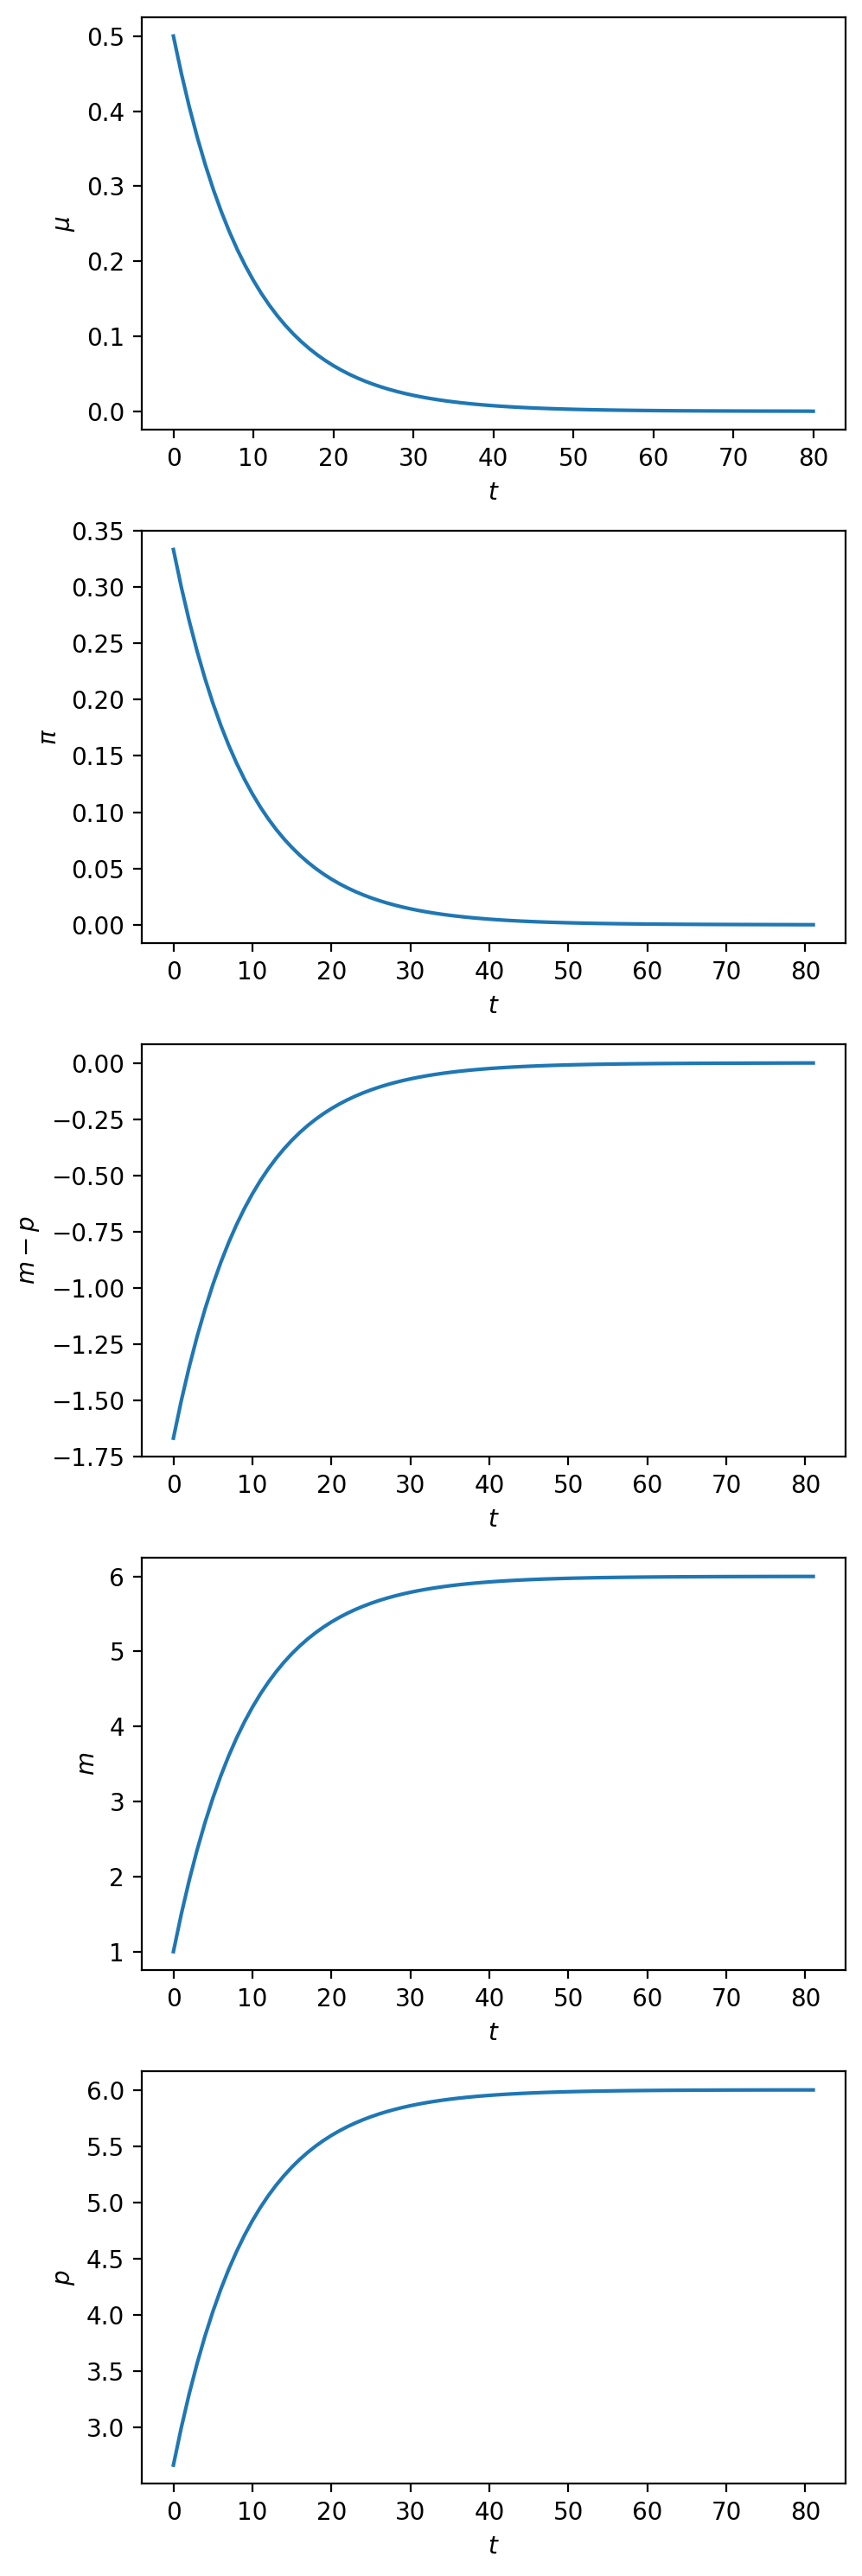

In [8]:
# parameters
ϕ = 0.9
μ_seq = np.array([ϕ**t * μ0 + (1-ϕ**t)*μ_star for t in range(T)])
μ_seq = np.append(μ_seq, μ_star)


# solve and plot
π_seq, m_seq, p_seq = solve_and_plot(m0=m0, α=α, T=T, μ_seq=μ_seq)